In [1]:
import numpy as np
from scipy import spatial
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os,sys
my_path = os.getcwd()
print (my_path)
path = os.path.join(my_path, "../data/ratings.txt")
print (path)

/home/surya/surya_114cs0121/AttackProfileDetectionRS/filmtrust/User-Based-Recommendation
/home/surya/surya_114cs0121/AttackProfileDetectionRS/filmtrust/User-Based-Recommendation/../data/ratings.txt


In [17]:
ratings = pd.read_csv(path,sep=' ',header=None,names=['userId','itemId','rating'])

In [18]:
ratings.describe()

,userId,itemId,rating
count,35497.000000,35497.000000,35497.000000
mean,744.247824,265.524946,3.002803
std,433.199457,346.854769,0.918692
min,1.000000,1.000000,0.500000
25%,356.000000,12.000000,2.500000
50%,735.000000,216.000000,3.000000
75%,1130.000000,251.000000,4.000000
max,1508.000000,2071.000000,4.000000


### Rating before profile injection

In [19]:
calculated_Rating = {}
total_Ratings = {}
all_items = ratings['itemId'].unique()

#rating
R = ratings.groupby(['itemId'])['rating'].mean()
for i in all_items:
#     print (i)
    calculated_Rating[i] = R[i]
    total_Ratings[i] = len(ratings[ratings['itemId']==i])
    
# print (calculated_Rating)

In [20]:
calculated_Rating[12]

2.804232804232804

### Inject Attack Profiles

In [21]:
window_items = [1, 2, 3, 4, 5, 257, 7, 8, 9, 10, 11, 13, 205, 17, 211, 213, 215, 219, 220, 234, 236, 239, 250, 255]
target_items = [12, 207, 216, 235, 241] 

In [22]:
push_rating = 4

In [23]:
attack_ids = list(range(1600,1700))

for attacker in attack_ids:
    for item in window_items:
        a = calculated_Rating[item]
        attack_rating = int(a) if (a-int(a)<0.5) else int(a)+1
        ratings = ratings.append(pd.Series([attacker,item,attack_rating], index=['userId', 'itemId' ,'rating']), ignore_index=True)

for attacker in attack_ids:
    for item in target_items:
        ratings = ratings.append(pd.Series([attacker,item,push_rating], index=['userId', 'itemId' ,'rating']), ignore_index=True)

### Rating after profile injection

In [24]:
calculated_Rating = {}
total_Ratings = {}
all_items = ratings['itemId'].unique()

#rating
R = ratings.groupby(['itemId'])['rating'].mean()
for i in all_items:
#     print (i)
    calculated_Rating[i] = R[i]
    total_Ratings[i] = len(ratings[ratings['itemId']==i])
    
# print (calculated_Rating)

In [25]:
calculated_Rating[12]

2.94392523364486

### Reading trust values

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
with h5py.File('trust_values_user_push_total.h5', 'r') as hf:
    trust_val = hf['trust'][:]

In [27]:
x = [i for i in range(0,11)]
y = []
total = trust_val.shape[0]*trust_val.shape[1]
for i in x:
    y.append(len(np.where(trust_val>(i/10))[0])/total)

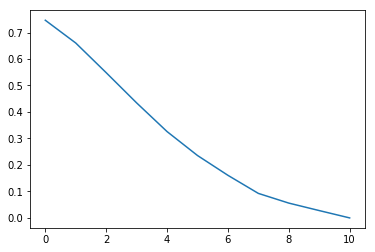

In [28]:
plt.plot(x,y)

## Trust propagated deviation

In [29]:
users = attack_ids[:1] 
print (users)

[1600]


### Iterative approach 

### Recursive approach 

In [30]:
def propagate(user,u_th):
    user_trust = trust_val[user][0:]
    user_who_rated_same_item = [int(i) for i in list(ratings[ratings['itemId']==item]['userId'])]
    consideredUsers = np.where(u_th*user_trust>trust_threshold)[0]
#         print (user_who_rated_same_item)
#         print (consideredUsers)
    trustee = [i for i in consideredUsers if((i in user_who_rated_same_item) and (not i in done_trustee))]
    if(len(trustee)==0):
        return
    else:
        for i in trustee:
            done_trustee.add(i)
    trustee_trust = [user_trust[i] for i in trustee]
    trustee_rating = [ratings[(ratings['itemId']==item) & (ratings['userId']==i)].reset_index(drop=True)['rating'][0] for i in trustee]
    for t_i, t_u in enumerate(trustee):
        propagate(t_u,trustee_trust[t_i])
    final_trustee.extend(trustee)
    final_trustee_trust.extend(trustee_trust)
    final_trustee_rating.extend(trustee_rating)

In [38]:
np.where(trust_val[1600][0:]>0.95)

(array([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610,
        1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621,
        1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632,
        1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643,
        1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654,
        1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665,
        1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676,
        1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687,
        1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698,
        1699]),)

In [40]:
trust_threshold = 0.95
deviation_threshold = 0.1

t1 = time.time()
for u in users:
    temp = ratings[ratings['userId']==u]
    items = temp['itemId'].unique()
    items.sort()
#     print (items)
    for item in items:
        done_trustee = set()
        final_trustee = []
        final_trustee_trust = []
        final_trustee_rating = []
        
        propagate(u,1)
        
        if sum(final_trustee_trust)!=0:
            rating_user_network = sum([final_trustee_trust[p]*q for p,q in enumerate(final_trustee_rating)])/sum(final_trustee_trust)
        else:
            rating_user_network = 0
            
        if (total_Ratings[item]-len(final_trustee_rating)) !=0:
            temp_calculated_Rating = (calculated_Rating[item]*total_Ratings[item]-sum(final_trustee_rating))/(total_Ratings[item]-len(final_trustee_rating))
        else:
            temp_calculated_Rating =0
        
        if(abs(temp_calculated_Rating-rating_user_network)>deviation_threshold):
            print ('Attack profile detected :', u ,' for item :',item)
        print (item)
#         print (calculated_Rating[item])
#         print (temp_calculated_Rating)
#         print (rating_user_network)
#         print (abs(temp_calculated_Rating-rating_user_network))   
        print (done_trustee)
        print ('\n')

print (time.time()-t1)

1
{1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699}


Attack profile detected : 1600  for item : 2
2
{1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657,

In [35]:
window_items = [1, 257, 4, 5, 8, 9, 10, 234, 12, 205, 235, 207, 239, 241, 211, 213, 216, 250, 219, 220, 255] 
target_items = [2, 3, 7, 11, 13, 17, 215, 236]

In [33]:
import random
t = []
for i in range(5):
    temp = []
    for j in range(5):
        temp.append(random.randint(1,10)/10)
    t.append(temp)
print (t)
t = np.array(t)
l = np.where(1.5*t>0.5)
print ([l[1][i] for i in range(len(l[0])) if l[0][i]==1 ])

[[0.5, 1.0, 0.9, 0.8, 0.4], [1.0, 0.3, 1.0, 0.1, 0.4], [0.4, 0.6, 1.0, 0.5, 0.6], [1.0, 1.0, 0.5, 0.3, 0.5], [0.9, 0.6, 0.4, 0.4, 0.8]]
[0, 2, 4]


In [ ]:
for it in items:
    #user = user who rated it

    for u in user:
        l = np.where(trust_val>0.3)
        trustee = [l[1][i] for i in range(len(l[0])) if l[0][i]==u]
        trustee_trust = [trust_val[l[0][i]][l[1][i]] for i in range(len(l))]
        done_trustee = []
        for t_i, t_u in enumerate(trustee):
            if t_u in done_trustee:
                continue
            else:
                done_trustee.append(t_u)

                temp_trust = trustee_trust[t_i]
                t_l = np.where(temp_trust*trust_val>0.3)

                temp_trustee = [t_l[1][i] for i in range(len(t_l[0])) if t_l[0][i]==u]
                trustee.extend(temp_trustee)
                temp_trustee_trust = [temp_trust*trust_val[t_l[0][i]][t_l[1][i]] for i in range(len(t_l))]
                trustee_trust.extend(temp_trustee_trust)

            if(t_i==len(trustee)):
                break

        #predict using trustee and trustee_trust
        #check deviation 
        #declare u and it's network as attack profile for the particular item

In [43]:
a =[3,3]
for j,i in enumerate(a):
    print (j)
    if len(a)==j:
        break
        
    if i<8:
        a.append(i*2)
        print (j,'  ','add')
    else:
        pass
    
print (a)

0
0    add
1
1    add
2
2    add
3
3    add
4
5
[3, 3, 6, 6, 12, 12]


In [35]:
a

[3, 2, 1, 4, 5]